In [37]:
# instalamos librería pca
!pip install -q pca
!pip install --upgrade plotly --q

# Tratamiento de datos
# ==============================================================================
import pandas as pd
from pandas.plotting import table
import numpy as np
import statsmodels.api as sm
import sklearn
import six
import ftplib
import os
import math

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.dates import date2num, num2date
import seaborn as sns
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib import animation
plt.style.use("ggplot")# for pretty graphs
from IPython.display import clear_output
import plotly.express as px

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.cluster import k_means
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

# Configuración warnings
# ==============================================================================
import warnings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd

In [38]:
path = 'https://raw.githubusercontent.com/arthurbaleeiro/ArtBaleeiro/main/TFMCSV.csv'
bd_epidem = pd.read_csv(path, sep=";")
bd_epidem.head()

,Column1,fecha,iso,ccaa,sexo,edad,poblacion,confirmados,hospitalizados,uci,fallecidos,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,1,01/01/2020,AN,Andalucía,Total,Total,8465236,0,3,0,0,NaN,NaN,NaN
1,2,01/01/2020,AN,Andalucía,Total,0-9,786909,0,0,0,0,NaN,NaN,NaN
2,3,01/01/2020,AN,Andalucía,Total,10-19,955318,0,0,0,0,NaN,NaN,NaN
3,4,01/01/2020,AN,Andalucía,Total,20-29,922665,0,0,0,0,NaN,NaN,NaN
4,5,01/01/2020,AN,Andalucía,Total,30-39,1108837,0,1,0,0,NaN,NaN,NaN


In [39]:
# Quitar las columnas con datos irrelevantes o sin uso

bd_epidem = bd_epidem.drop(columns=['Unnamed: 11','Unnamed: 12', 'Unnamed: 13', 'Column1'])
bd_epidem.head(5)

,fecha,iso,ccaa,sexo,edad,poblacion,confirmados,hospitalizados,uci,fallecidos
0,01/01/2020,AN,Andalucía,Total,Total,8465236,0,3,0,0
1,01/01/2020,AN,Andalucía,Total,0-9,786909,0,0,0,0
2,01/01/2020,AN,Andalucía,Total,10-19,955318,0,0,0,0
3,01/01/2020,AN,Andalucía,Total,20-29,922665,0,0,0,0
4,01/01/2020,AN,Andalucía,Total,30-39,1108837,0,1,0,0


In [40]:
# Calculo y Estimacion del numero de recuperados

bd_epidem['recuperados'] = bd_epidem['confirmados'] - bd_epidem['fallecidos']
bd_epidem.head(5)

,fecha,iso,ccaa,sexo,edad,poblacion,confirmados,hospitalizados,uci,fallecidos,recuperados
0,01/01/2020,AN,Andalucía,Total,Total,8465236,0,3,0,0,0
1,01/01/2020,AN,Andalucía,Total,0-9,786909,0,0,0,0,0
2,01/01/2020,AN,Andalucía,Total,10-19,955318,0,0,0,0,0
3,01/01/2020,AN,Andalucía,Total,20-29,922665,0,0,0,0,0
4,01/01/2020,AN,Andalucía,Total,30-39,1108837,0,1,0,0,0


In [41]:
# Calculo y Estimacion de R0 (La tasa de transmicion de la epidemia)

bd_epidem['R0'] =  (bd_epidem['confirmados'] * bd_epidem['poblacion'])/(bd_epidem['recuperados'] * bd_epidem['poblacion']- bd_epidem['recuperados']-bd_epidem['fallecidos'])
bd_epidem.describe()

,poblacion,confirmados,hospitalizados,uci,fallecidos,recuperados,R0
count,4.055040e+05,405504.000000,405504.000000,405504.000000,405504.000000,405504.000000,2.091190e+05
mean,2.393836e+05,35.854512,3.524098,0.331282,0.783825,35.070687,-1.205590e+03
std,6.694737e+05,180.262150,20.410254,1.856880,4.912941,177.866362,3.297994e+04
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-28.000000,-4.295289e+06
25%,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000004e+00
50%,6.314100e+04,1.000000,0.000000,0.000000,0.000000,1.000000,1.000011e+00
75%,1.944260e+05,15.000000,1.000000,0.000000,0.000000,15.000000,1.000075e+00
max,8.465236e+06,9583.000000,1930.000000,135.000000,334.000000,9490.000000,2.900022e+01


In [42]:
# FILTRO EN RECUPERADOS - Los valores negativos no tienen sentido real y aparecen sobretodo debido a la falta de datos al principio de la pandemia - los pasaremos a cero
bd_epidem.recuperados = np.where(bd_epidem.recuperados < 0, 0, bd_epidem.recuperados)

# FILTRO EN R0 - Trabajaremos solamente con los valores de R0 que tienen un sentido real. Todos valores fueara del rango de 0 a 10 seran eliminados 
bd_epidem = bd_epidem[(bd_epidem.R0 >= 0) & (bd_epidem.R0 <= 10)]

# PASAR R0 A NUMERICO
bd_epidem['R0'] = bd_epidem['R0'].astype(float)

# ELIMINAR CASOS EN QUE LA POBLACION ES CERO 
bd_epidem = bd_epidem[(bd_epidem.poblacion != 0)]

# ELIMINAR CASOS EN QUE GENERO ES NULO O TOTAL
bd_epidem = bd_epidem[(bd_epidem.sexo != 'Total') & (bd_epidem.sexo != 'NC')]

# PASAR GENERO A FACTOR
bd_epidem['sexo'] = bd_epidem ['sexo'].astype('category')

# ELIMINAR CASOS EN QUE EDAD ES NULO O TOTAL
bd_epidem = bd_epidem[(bd_epidem.edad != 'Total') & (bd_epidem.edad != 'NC')]

# PASAR EDAD A FACTOR
bd_epidem['edad'] = bd_epidem ['edad'].astype('category')

# PASAR CCAA A FACTOR
bd_epidem['ccaa'] = bd_epidem ['ccaa'].astype('category')

# PASAR ISO A FACTOR
bd_epidem['iso'] = bd_epidem ['iso'].astype('category')

bd_epidem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116855 entries, 14107 to 405491
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   fecha           116855 non-null  object  
 1   iso             116855 non-null  category
 2   ccaa            116855 non-null  category
 3   sexo            116855 non-null  category
 4   edad            116855 non-null  category
 5   poblacion       116855 non-null  int64   
 6   confirmados     116855 non-null  int64   
 7   hospitalizados  116855 non-null  int64   
 8   uci             116855 non-null  int64   
 9   fallecidos      116855 non-null  int64   
 10  recuperados     116855 non-null  int64   
 11  R0              116855 non-null  float64 
dtypes: category(4), float64(1), int64(6), object(1)
memory usage: 8.5+ MB


In [43]:
bd_epidem.describe().T

,count,mean,std,min,25%,50%,75%,max
poblacion,116855.0,162451.270754,158833.941609,1732.0,52228.000000,102549.000000,199254.000000,687514.000000
confirmados,116855.0,30.929519,59.558073,0.0,4.000000,10.000000,30.000000,828.000000
hospitalizados,116855.0,2.984810,8.575049,0.0,0.000000,1.000000,2.000000,269.000000
uci,116855.0,0.281751,1.007781,0.0,0.000000,0.000000,0.000000,35.000000
fallecidos,116855.0,0.637559,2.969028,0.0,0.000000,0.000000,0.000000,100.000000
recuperados,116855.0,30.301964,59.167918,0.0,3.000000,10.000000,29.000000,828.000000
R0,116855.0,1.044121,0.279050,-0.0,1.000006,1.000012,1.000038,9.001702


In [44]:
# VERIFICACION DE NULOS
bd_epidem.isnull().sum()

fecha             0
iso               0
ccaa              0
sexo              0
edad              0
poblacion         0
confirmados       0
hospitalizados    0
uci               0
fallecidos        0
recuperados       0
R0                0
dtype: int64

In [45]:
# ANALISIS DE LOS DATOS
  # (Con los filtos y tratamientos previos llegamos a la base de datos final - "bd_trat")
# MATRIZ DE CORRELACION

corr_var = bd_epidem.corr(method="spearman",)
print("Matriz de correlación de Spearman:")
print("="*80)
corr_var.style.background_gradient(cmap='coolwarm')

# "SON LOS DATOS QUE DISPONEMOS"
# Vemos una alta correlacion entre el nulmero de confirmados y el de recuperados. Esa correlacion es normal porque sus valores estan bastante relacionados. Hay una alta recuperacion de los casos confirmamos - Se habla de un numero de fallecidos inferior al 5%. 
# Las demas variables presentan un correlacion de media a baja.

Matriz de correlación de Spearman:


,poblacion,confirmados,hospitalizados,uci,fallecidos,recuperados,R0
poblacion,1.000000,0.521739,0.343575,0.230524,0.106576,0.520031,-0.618730
confirmados,0.521739,1.000000,0.471653,0.285755,0.199148,0.995499,-0.199157
hospitalizados,0.343575,0.471653,1.000000,0.472383,0.494307,0.443854,0.112713
uci,0.230524,0.285755,0.472383,1.000000,0.300538,0.277098,0.085893
fallecidos,0.106576,0.199148,0.494307,0.300538,1.000000,0.139926,0.590750
recuperados,0.520031,0.995499,0.443854,0.277098,0.139926,1.000000,-0.236408
R0,-0.618730,-0.199157,0.112713,0.085893,0.590750,-0.236408,1.000000


In [46]:
  # Analisis de la Correlacion:

correlation_mat =bd_epidem.corr( )
corr_pairs = correlation_mat.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort", ascending=False,)
print('Correlación de Person:')
print("="*42)
sorted_pairs

# Haciendo el analisi de correlacion de Person, vemos ademas, otras variables con alta correlacion. Hospitalizados-UCI y Fallecidos-UCI lo que parece bastante normal, porque en general todos los fallecidos han pasado por la UCI y un grand numero de hospitalizados llegaran a la UCI. 

Correlación de Person:


R0              R0                1.000000
recuperados     recuperados       1.000000
confirmados     confirmados       1.000000
hospitalizados  hospitalizados    1.000000
fallecidos      fallecidos        1.000000
uci             uci               1.000000
poblacion       poblacion         1.000000
recuperados     confirmados       0.998771
confirmados     recuperados       0.998771
uci             hospitalizados    0.657350
hospitalizados  uci               0.657350
fallecidos      hospitalizados    0.647292
hospitalizados  fallecidos        0.647292
recuperados     poblacion         0.502328
poblacion       recuperados       0.502328
confirmados     poblacion         0.501237
poblacion       confirmados       0.501237
hospitalizados  confirmados       0.390692
confirmados     hospitalizados    0.390692
hospitalizados  recuperados       0.360737
recuperados     hospitalizados    0.360737
R0              fallecidos        0.339731
fallecidos      R0                0.339731
confirmados

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff2778f23d0>,
      dtype=object)

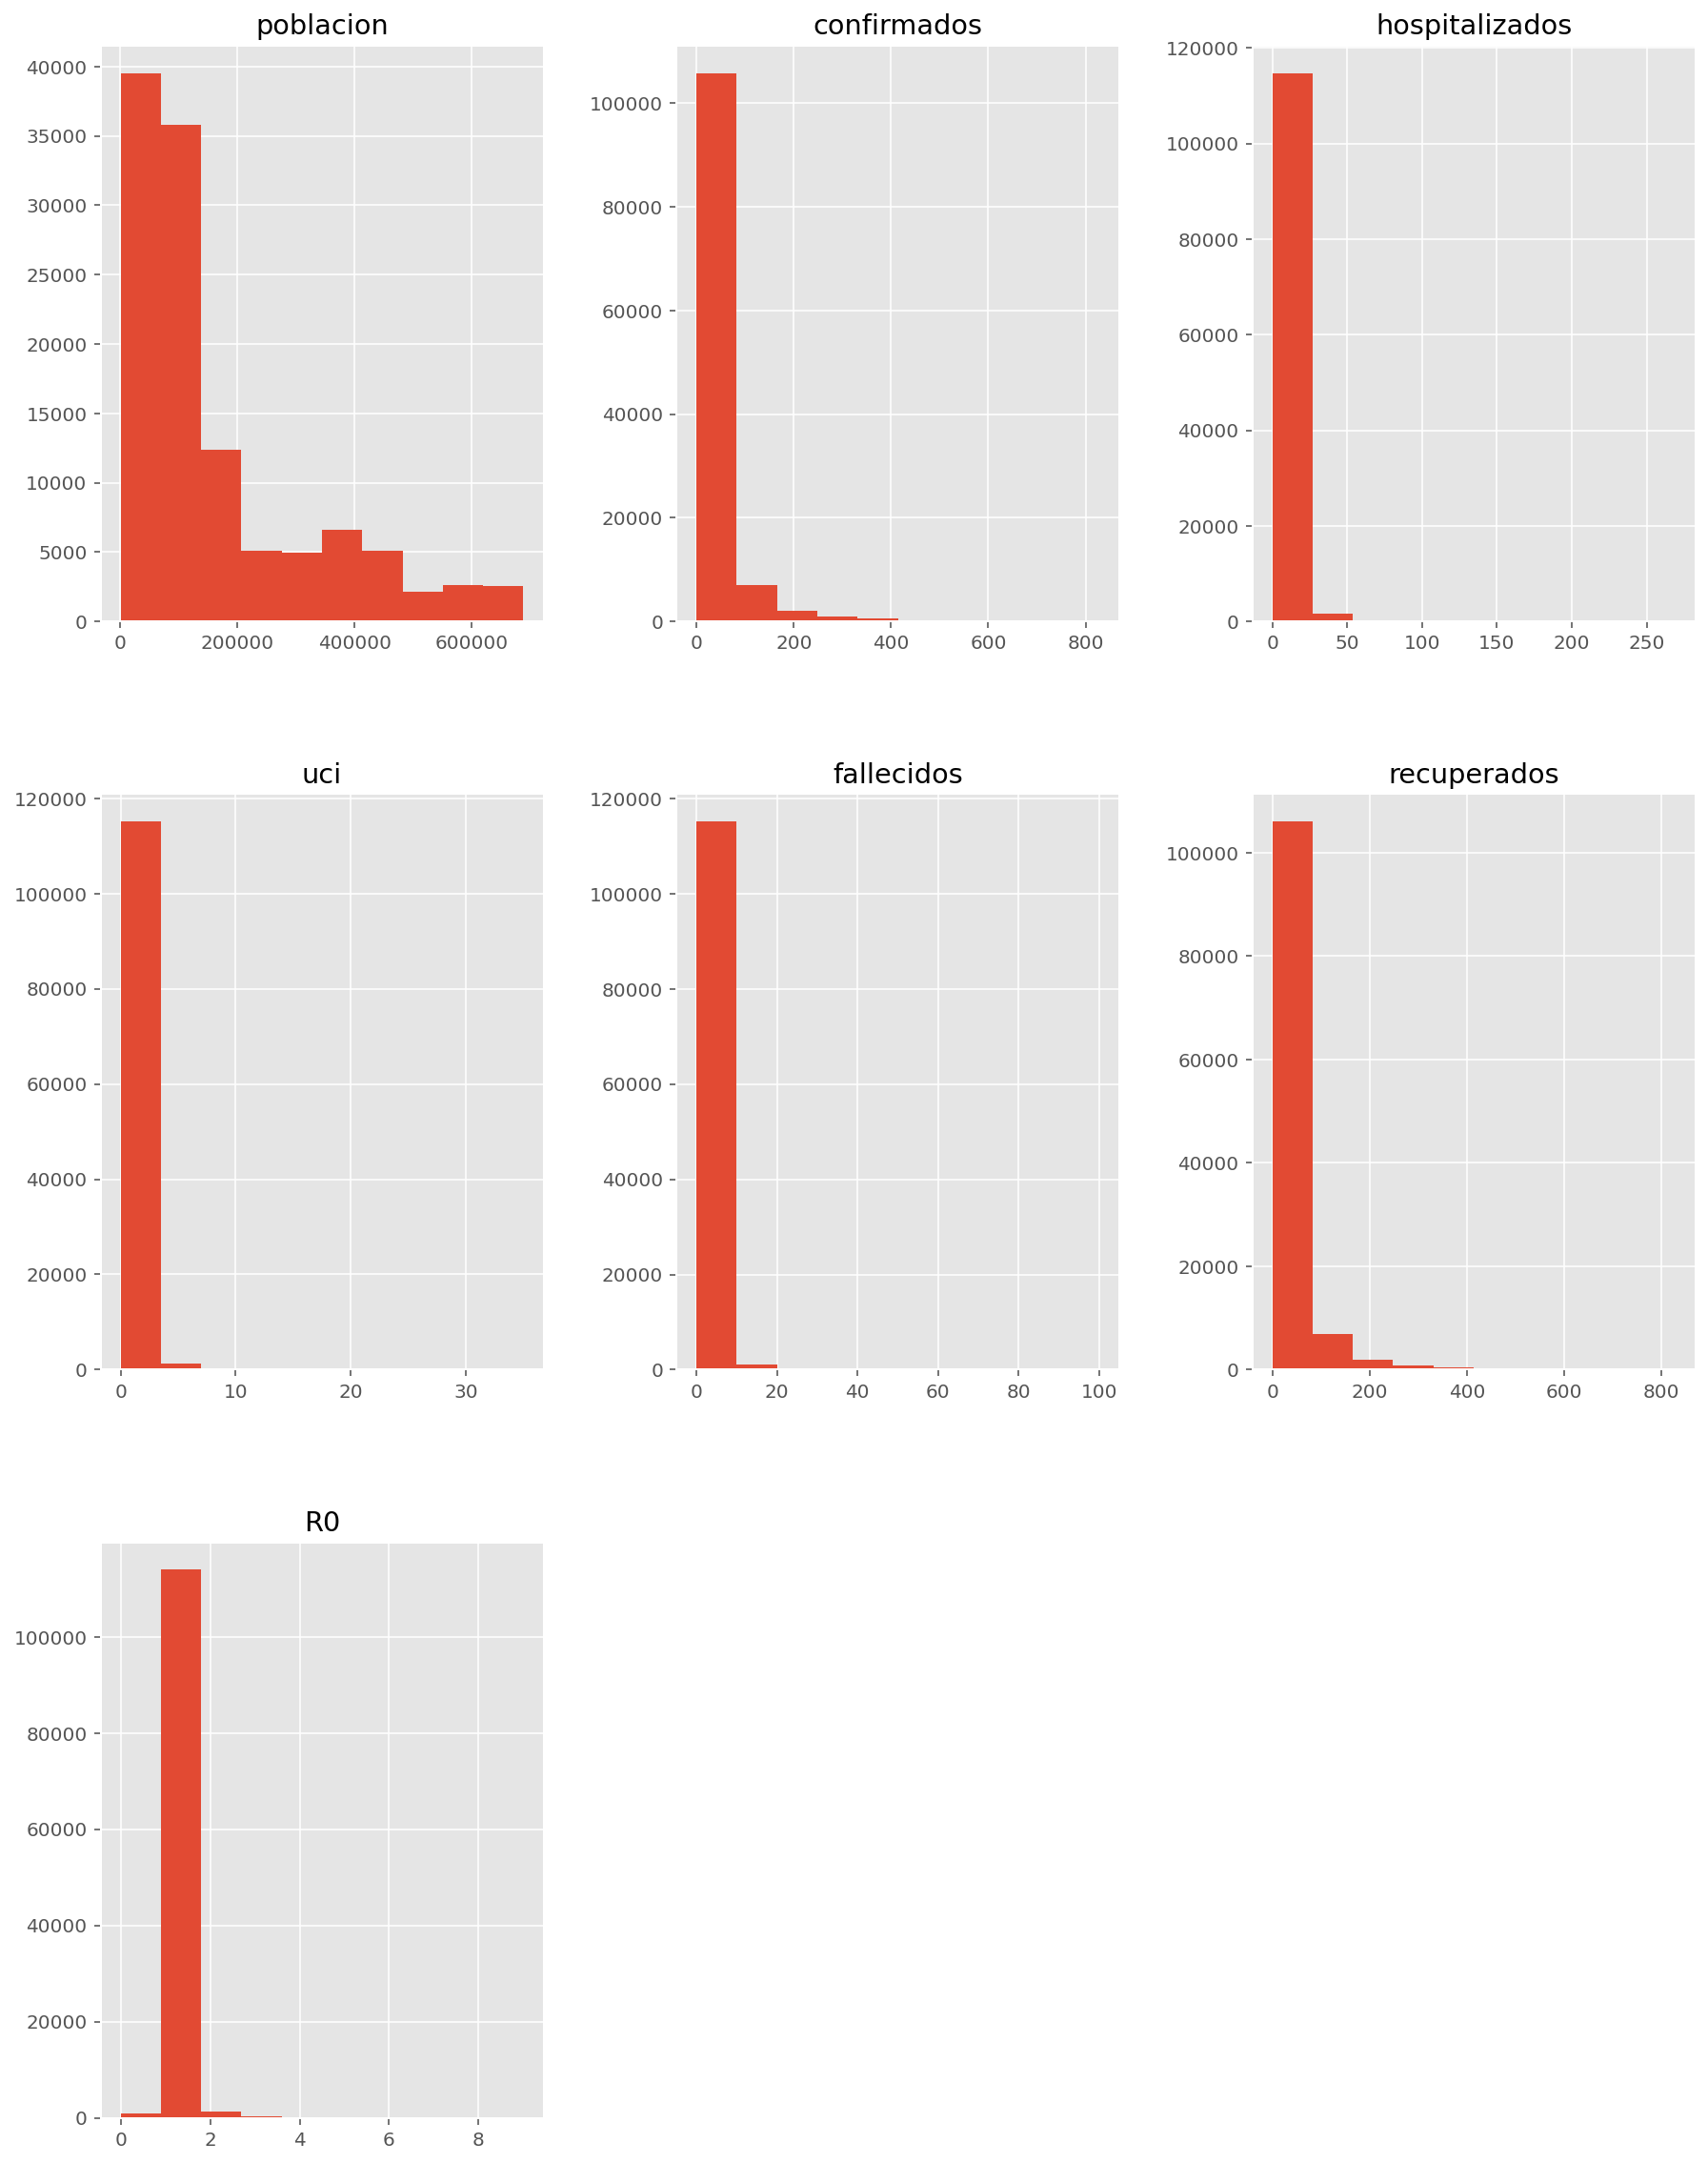

In [47]:
# HISTOGRAMA
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
bd_epidem.hist(ax = ax)


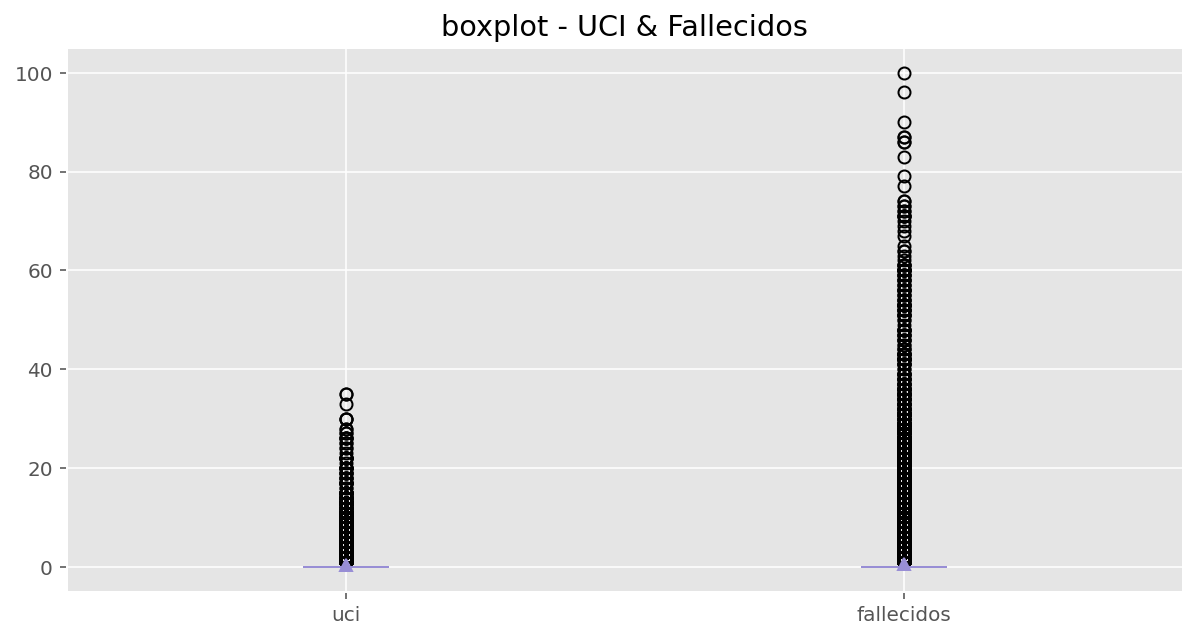

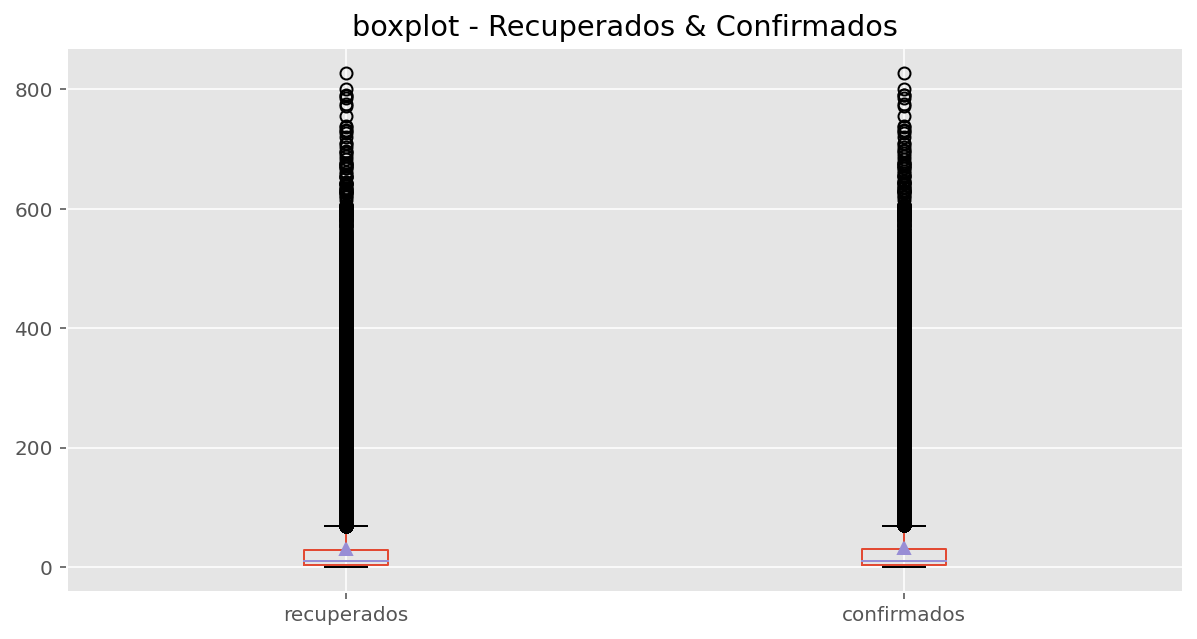

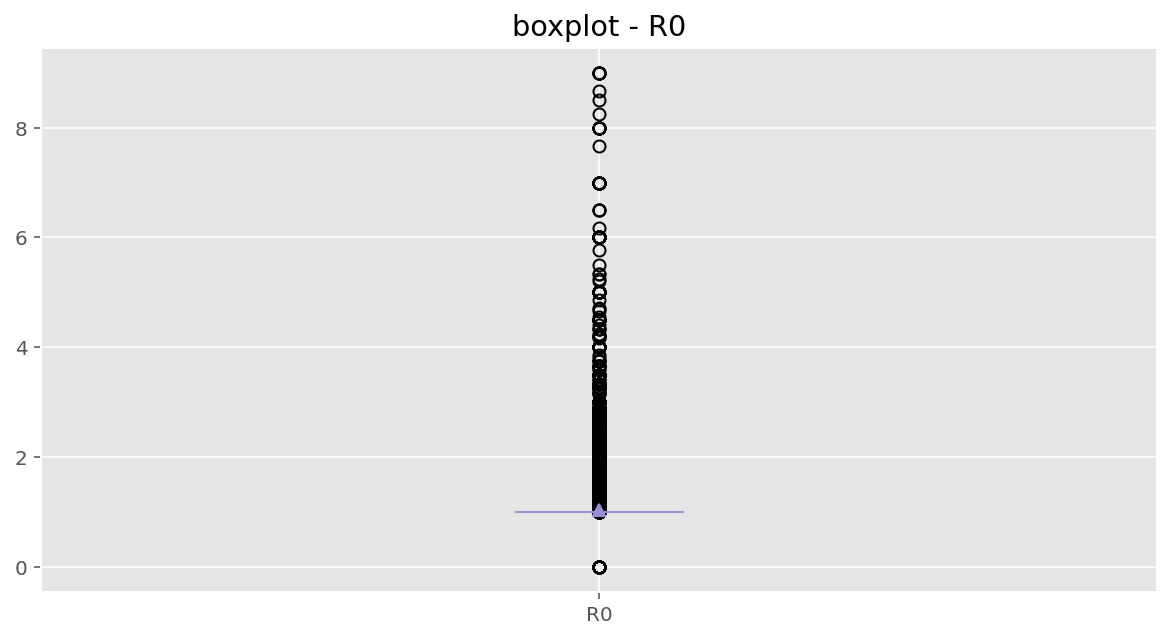

In [48]:
# BOXPLOT

ax = bd_epidem[['uci','fallecidos']].plot(kind='box', title='boxplot - UCI & Fallecidos', showmeans=True, figsize=(10, 5))
plt.show()


ax = bd_epidem[['recuperados','confirmados']].plot(kind='box', title='boxplot - Recuperados & Confirmados', showmeans=True, figsize=(10, 5))
plt.show()


# BOXPLOT
ax = bd_epidem[['R0']].plot(kind='box', title='boxplot - R0', showmeans=True, figsize=(10, 5))
plt.show()

In [49]:
bd_epidem_atipicos = bd_epidem
def atipicos(bd_epidem,Columnas):
  for c in Columnas:
    IQR=np.percentile(bd_epidem[c],75)-np.percentile(bd_epidem[c],25)
    M=np.mean(bd_epidem[c])
    CEINF=M-3*IQR
    CESUP=M+3*IQR
    bd_epidem['Atipicos_Cerc_'+c]=(bd_epidem[c]<CEINF)|(bd_epidem[c]>CESUP)
    bd_epidem['Atipicos_Perc_'+c]=(bd_epidem[c]<np.percentile(bd_epidem[c],1))|(bd_epidem[c]>np.percentile(bd_epidem[c],99))
atipicos(bd_epidem_atipicos,['poblacion','confirmados', 'hospitalizados', 'uci', 'fallecidos', 'recuperados', 'R0'])

In [50]:
def PROC_FREQ(bd_epidem,columnas):
  for c in columnas:
    x=bd_epidem[c].value_counts().to_frame()
    nombre=x.columns.tolist()[0]
    x.rename(columns={nombre:'Freq'},inplace=True)
    x['Pct']=x['Freq']/x.Freq.sum()
    x['Freq Acum'],x['Pct Acum']=x.Freq.cumsum(),x.Pct.cumsum()
    x.sort_values(['Freq'],ascending=[0],inplace=True)
    print('Tabla de distribución de frecuencias para la variable: '+nombre)
    print('\n')
    print(x)
    print('\n')

cols = [c for c in bd_epidem_atipicos.columns if 'Atipicos' in c]
PROC_FREQ(bd_epidem_atipicos,cols)

Tabla de distribución de frecuencias para la variable: Atipicos_Cerc_poblacion


         Freq       Pct  Freq Acum  Pct Acum
False  114299  0.978127     114299  0.978127
True     2556  0.021873     116855  1.000000


Tabla de distribución de frecuencias para la variable: Atipicos_Perc_poblacion


         Freq       Pct  Freq Acum  Pct Acum
False  115003  0.984151     115003  0.984151
True     1852  0.015849     116855  1.000000


Tabla de distribución de frecuencias para la variable: Atipicos_Cerc_confirmados


         Freq       Pct  Freq Acum  Pct Acum
False  109117  0.933781     109117  0.933781
True     7738  0.066219     116855  1.000000


Tabla de distribución de frecuencias para la variable: Atipicos_Perc_confirmados


         Freq       Pct  Freq Acum  Pct Acum
False  114788  0.982311     114788  0.982311
True     2067  0.017689     116855  1.000000


Tabla de distribución de frecuencias para la variable: Atipicos_Cerc_hospitalizados


         Freq      Pct  Freq Acum  Pct

Text(0, 0.5, 'Conteo')

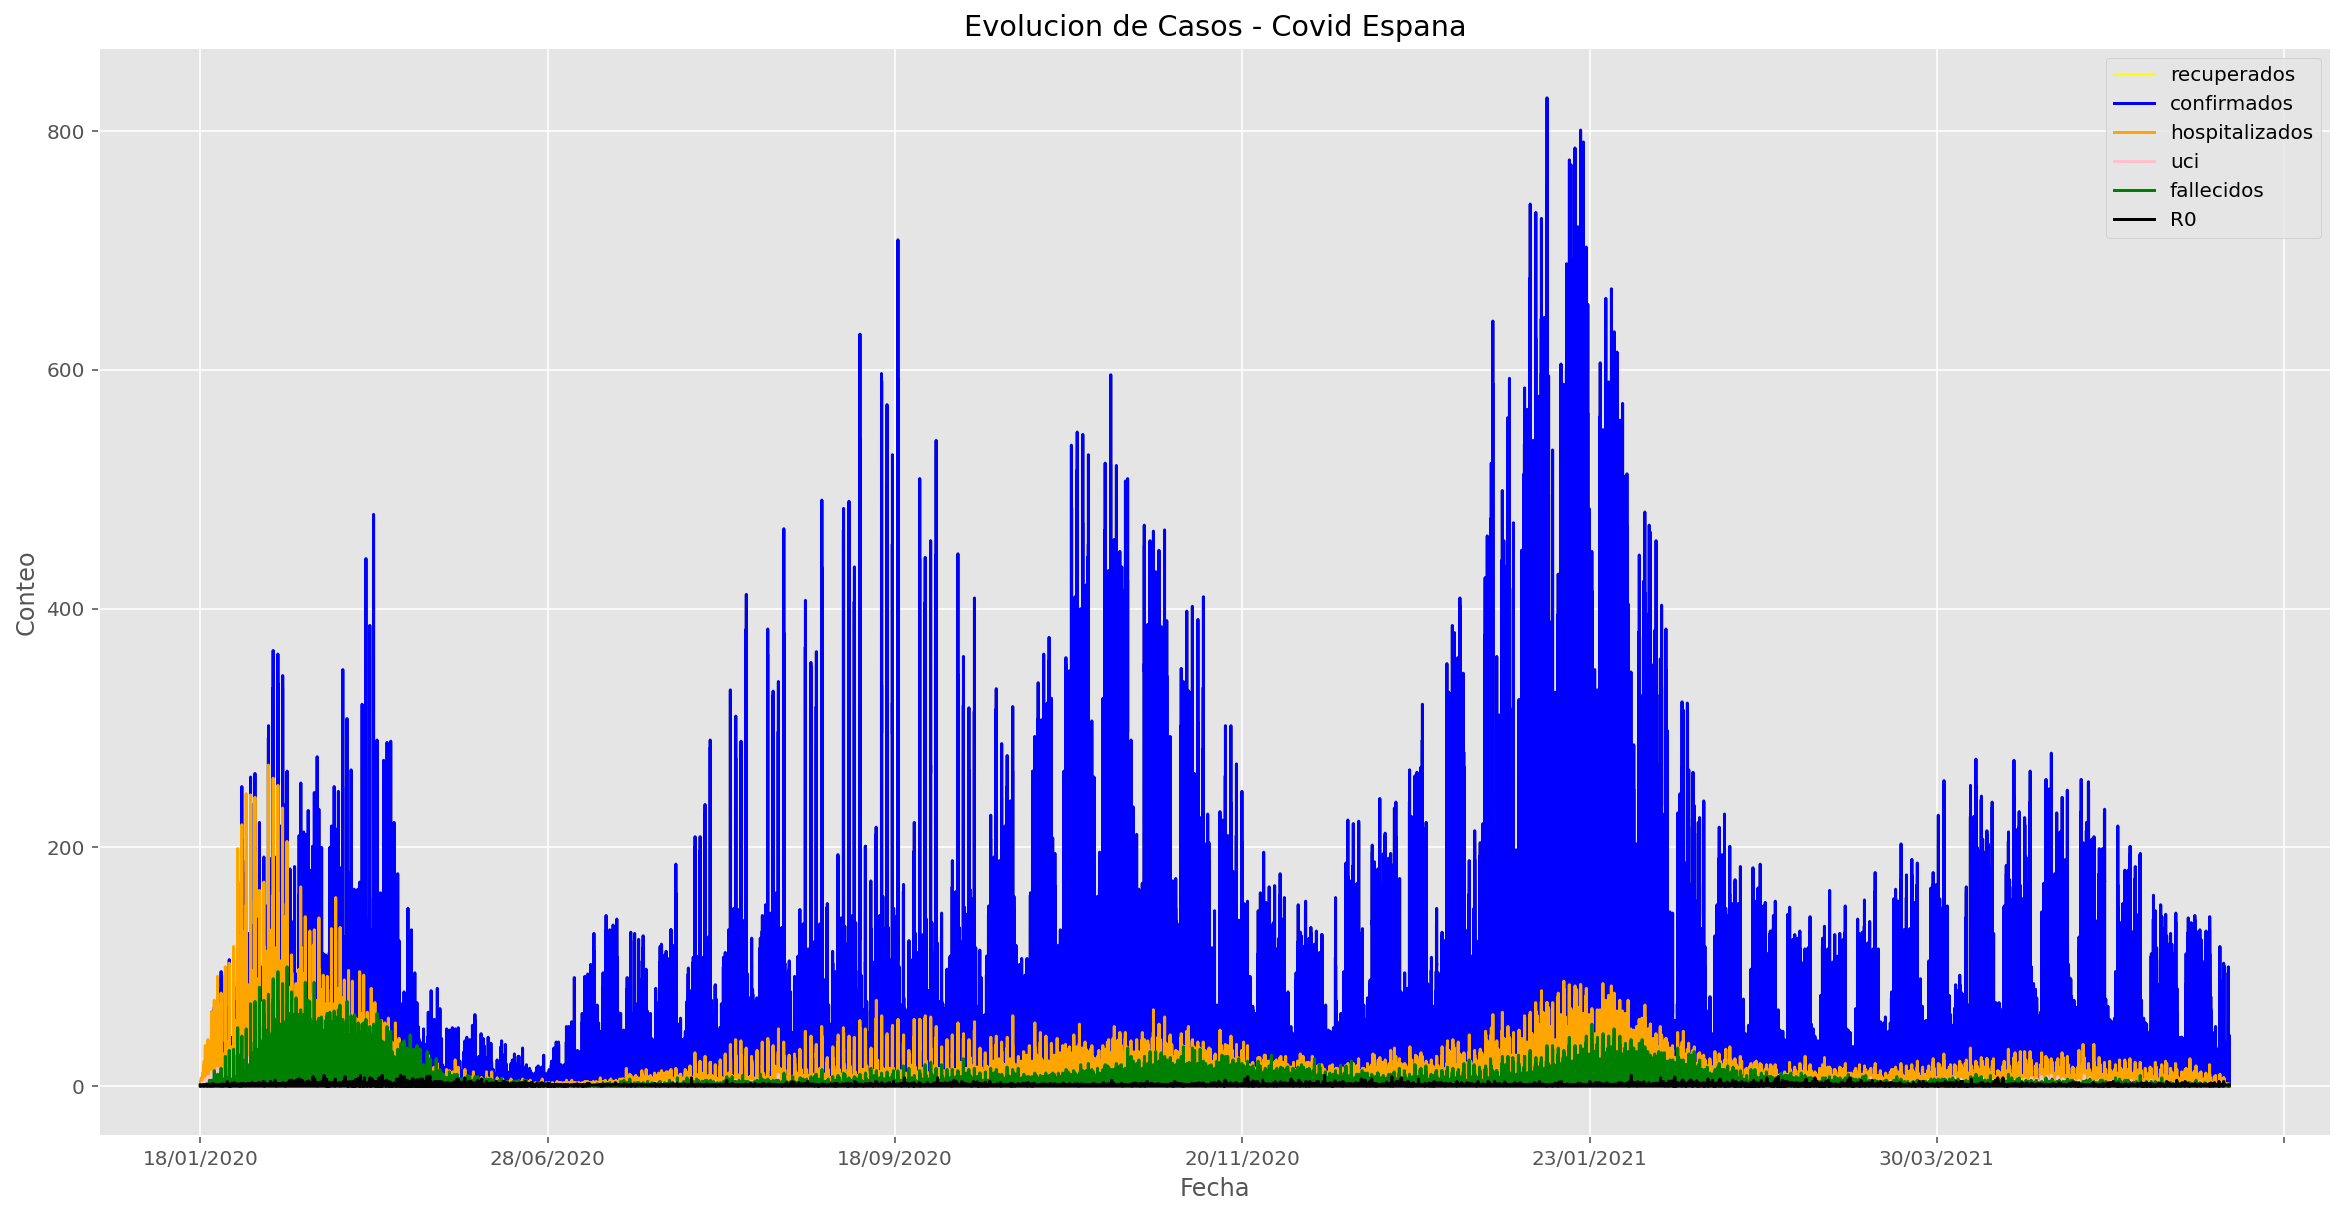

In [51]:
style.use('ggplot')
ax = plt.gca()
bd_epidem.plot.line(x='fecha', y='recuperados', color='yellow', ax=ax)
bd_epidem.plot.line(x='fecha', y='confirmados', color='blue', ax=ax, figsize=(20, 10))
bd_epidem.plot.line(x='fecha', y='hospitalizados', color='orange', ax=ax)
bd_epidem.plot.line(x='fecha', y='uci', color='pink', ax=ax)
bd_epidem.plot.line(x='fecha', y='fallecidos', color='green', ax=ax)
bd_epidem.plot.line(x='fecha', y='R0', color='black', ax=ax)
plt.title('Evolucion de Casos - Covid Espana')
plt.xlabel('Fecha')
plt.ylabel('Conteo')

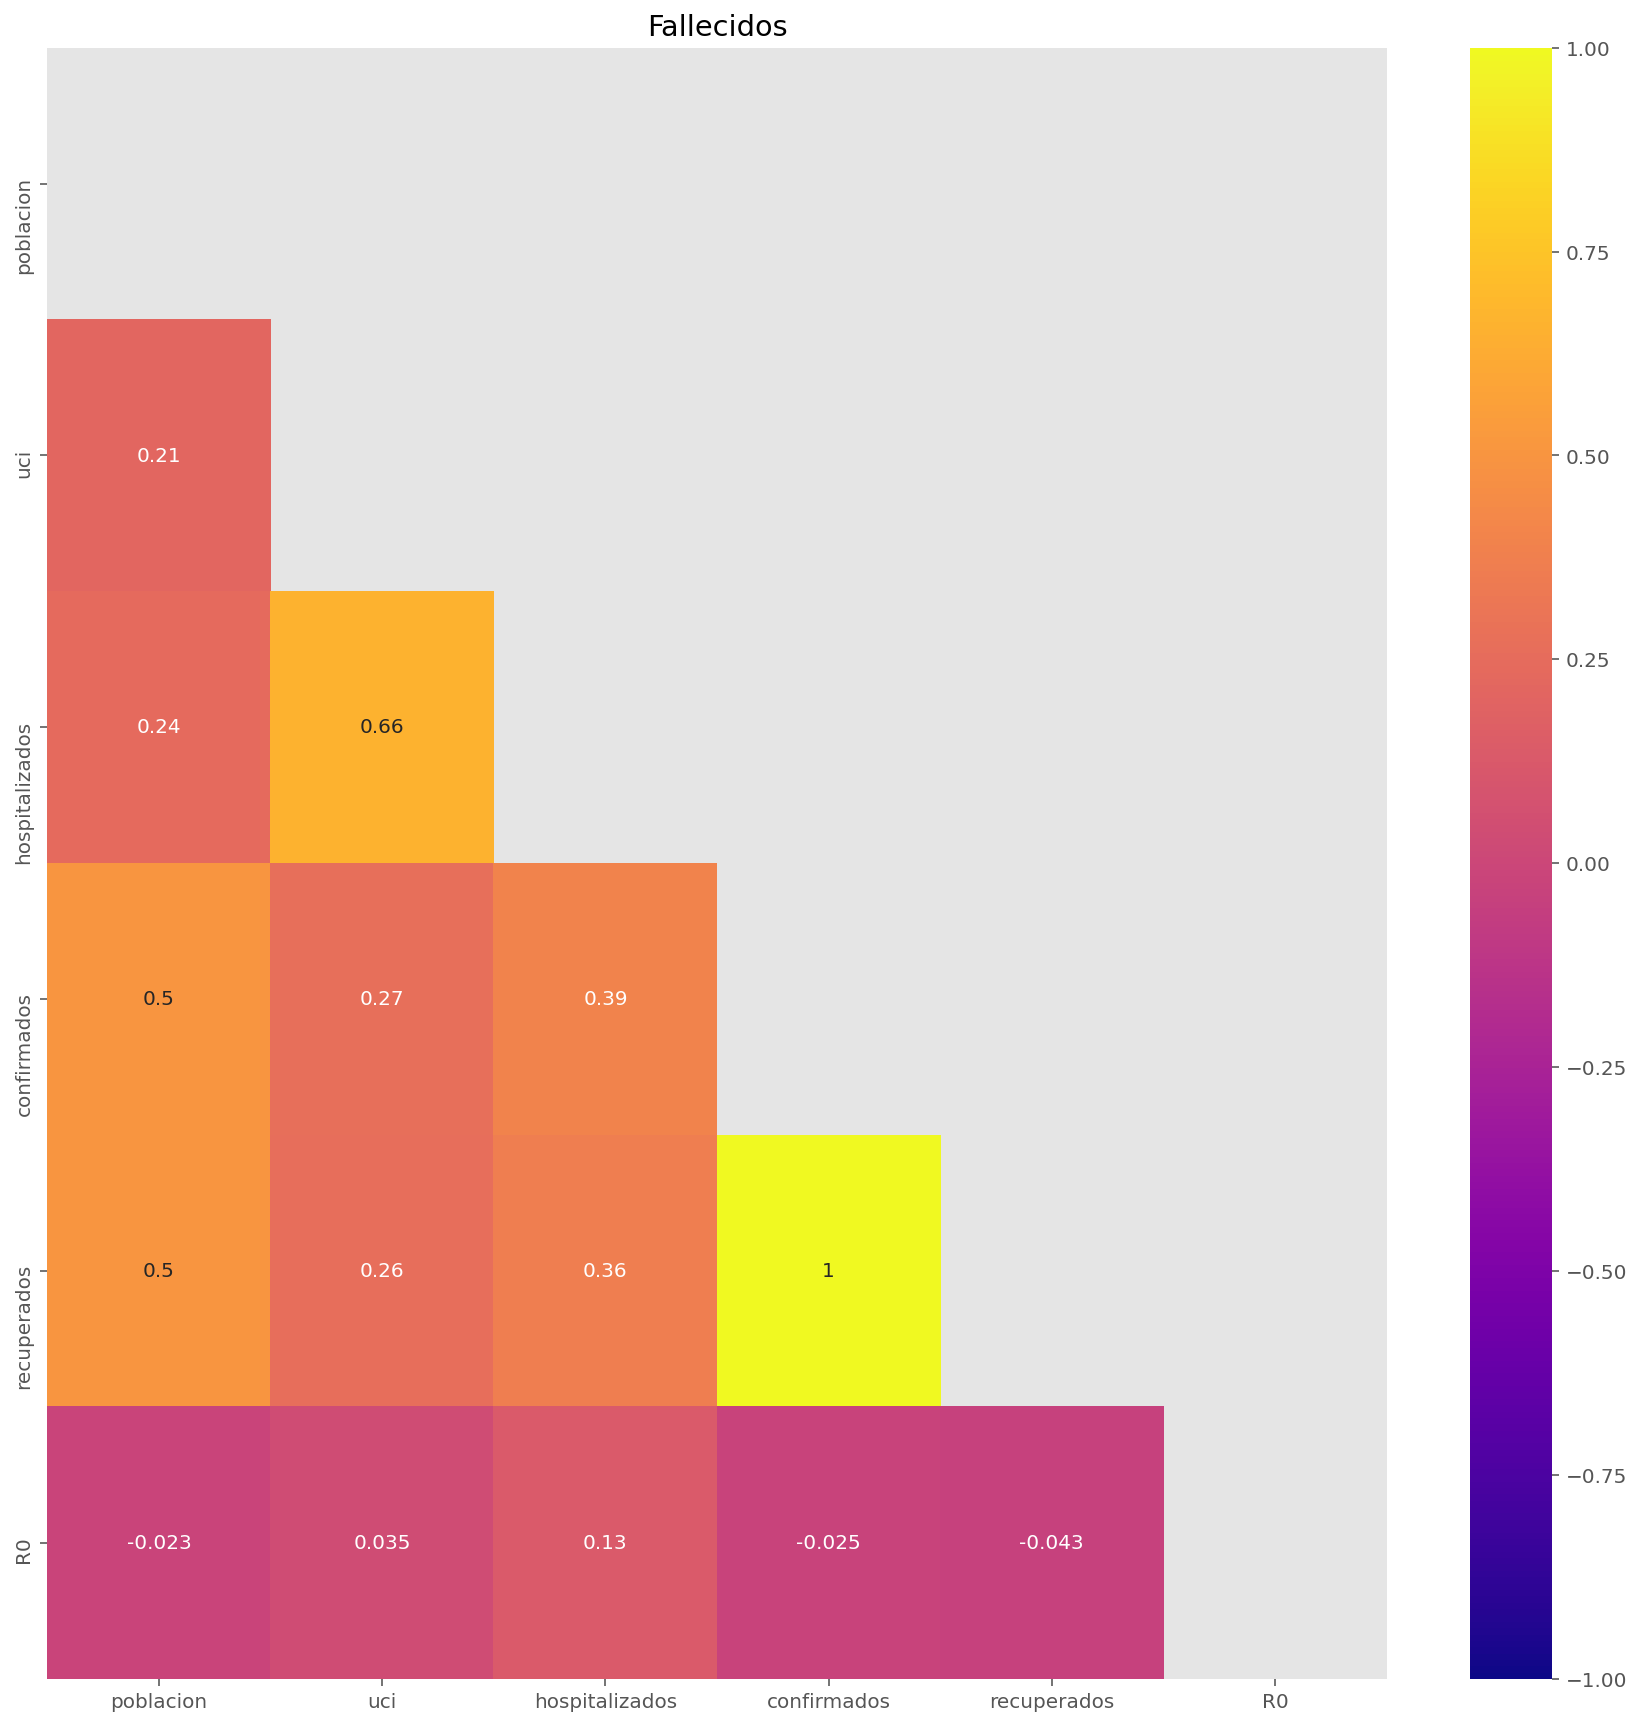

In [52]:

bd_fal = bd_epidem[['poblacion','uci', 'hospitalizados','confirmados','recuperados', 'R0']]

#MATRIZ DE CORRELACIONES 
colormap = plt.cm.plasma
matrix1 = np.triu(bd_fal.corr())
plt.figure(figsize=(15, 15))
sns.heatmap(bd_fal.corr(), annot=True, vmax=1, vmin=-1, mask=matrix1, cmap=colormap)
plt.title("Fallecidos")
plt.show()

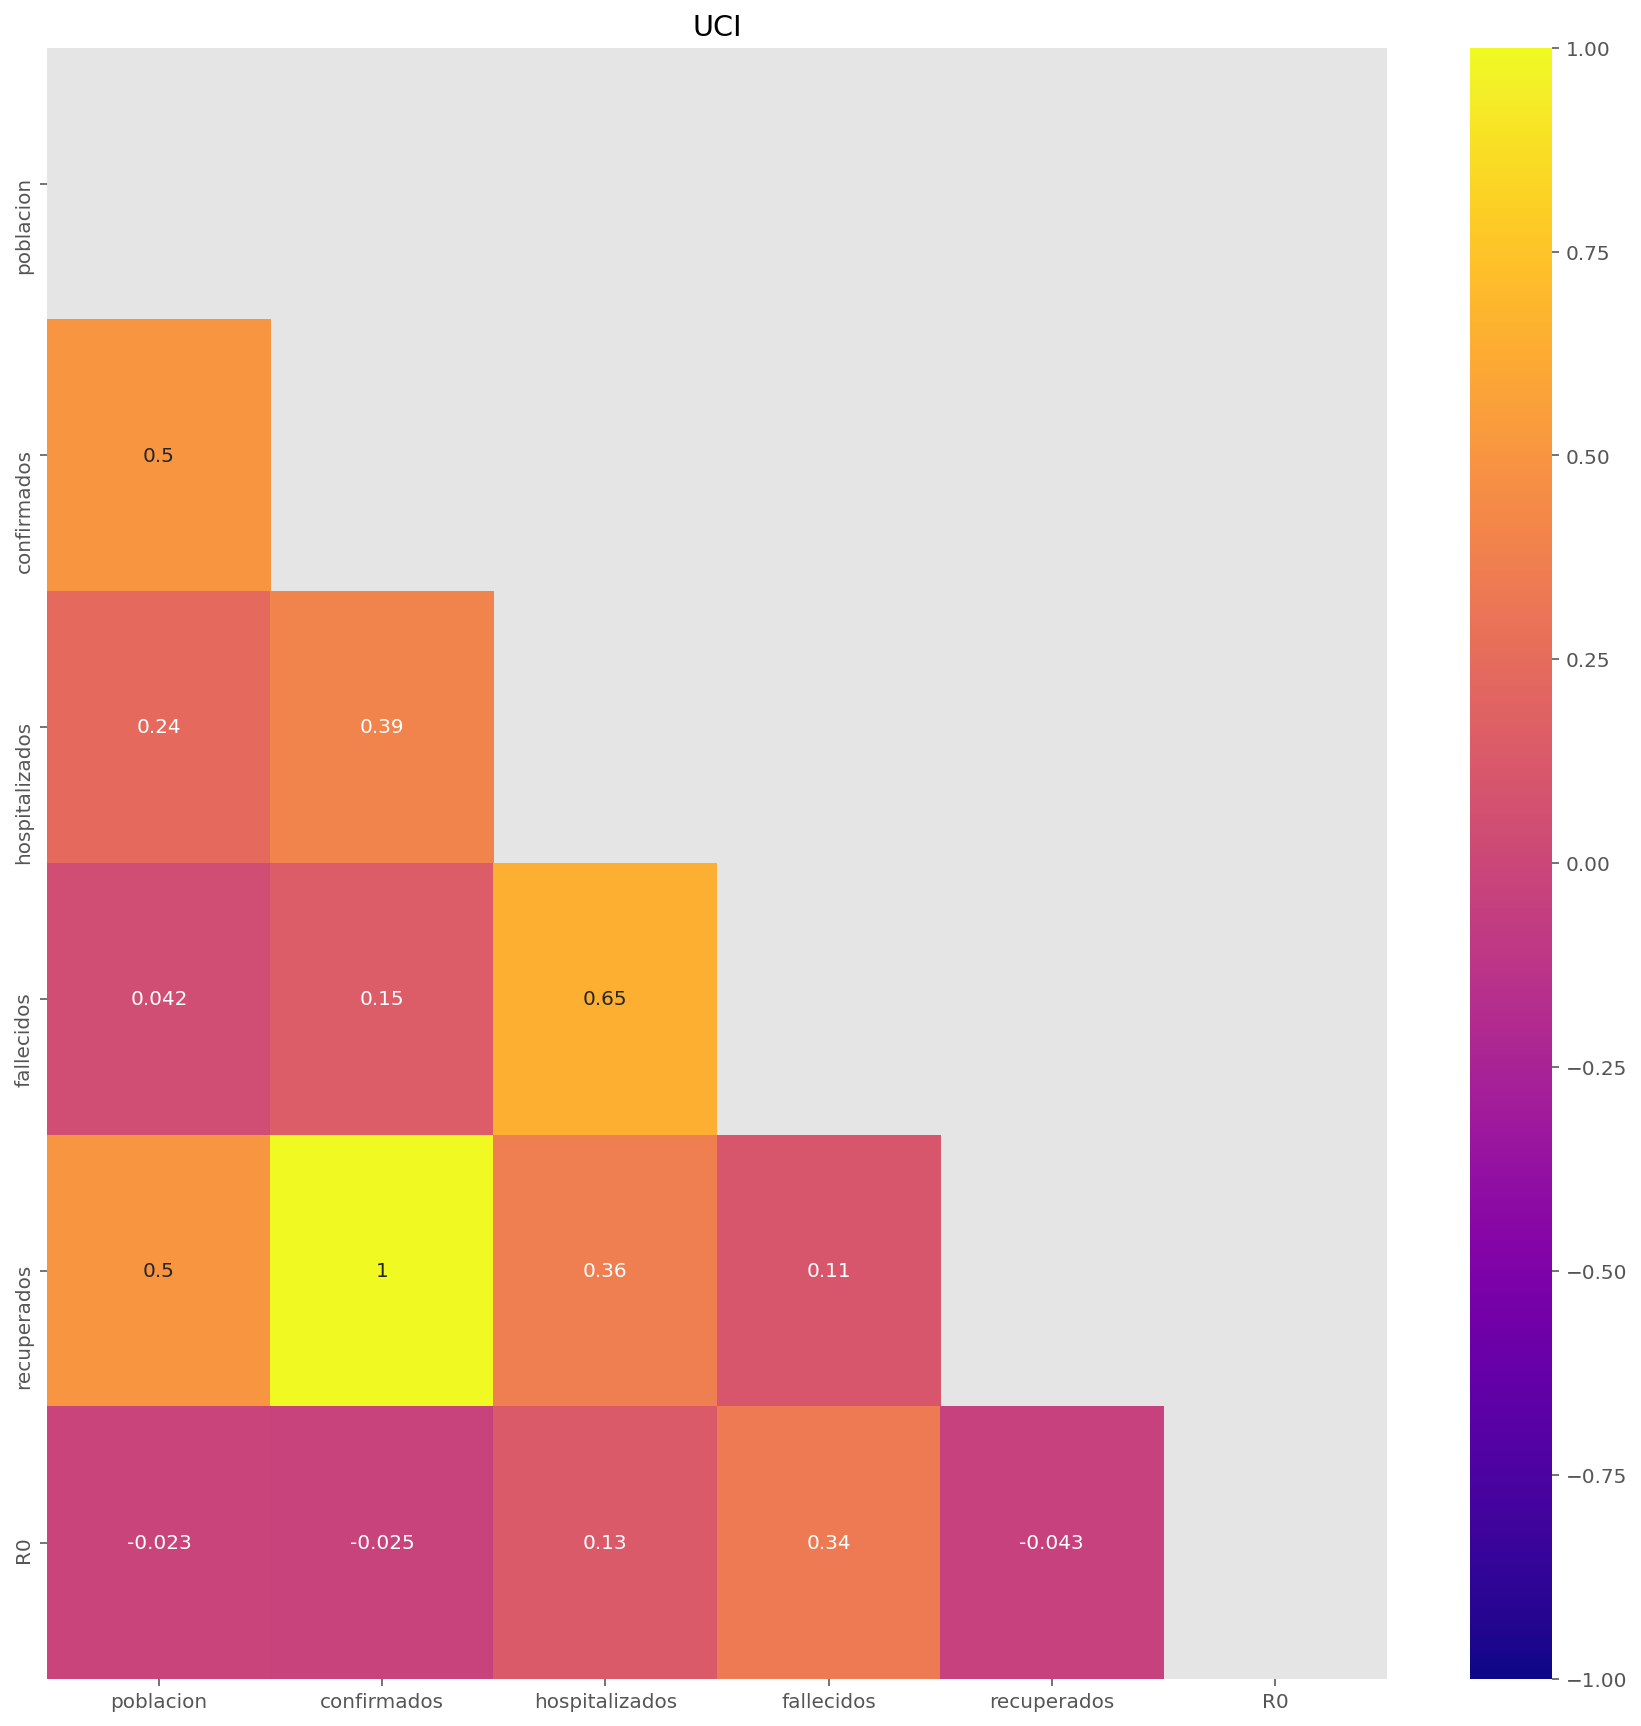

In [53]:
bd_uci = bd_epidem[['poblacion','confirmados', 'hospitalizados','fallecidos','recuperados', 'R0']]

#MATRIZ DE CORRELACIONES 
colormap = plt.cm.plasma
matrix1 = np.triu(bd_uci.corr())
plt.figure(figsize=(15, 15))
sns.heatmap(bd_uci.corr(), annot=True, vmax=1, vmin=-1, mask=matrix1, cmap=colormap)
plt.title("UCI")
plt.show()

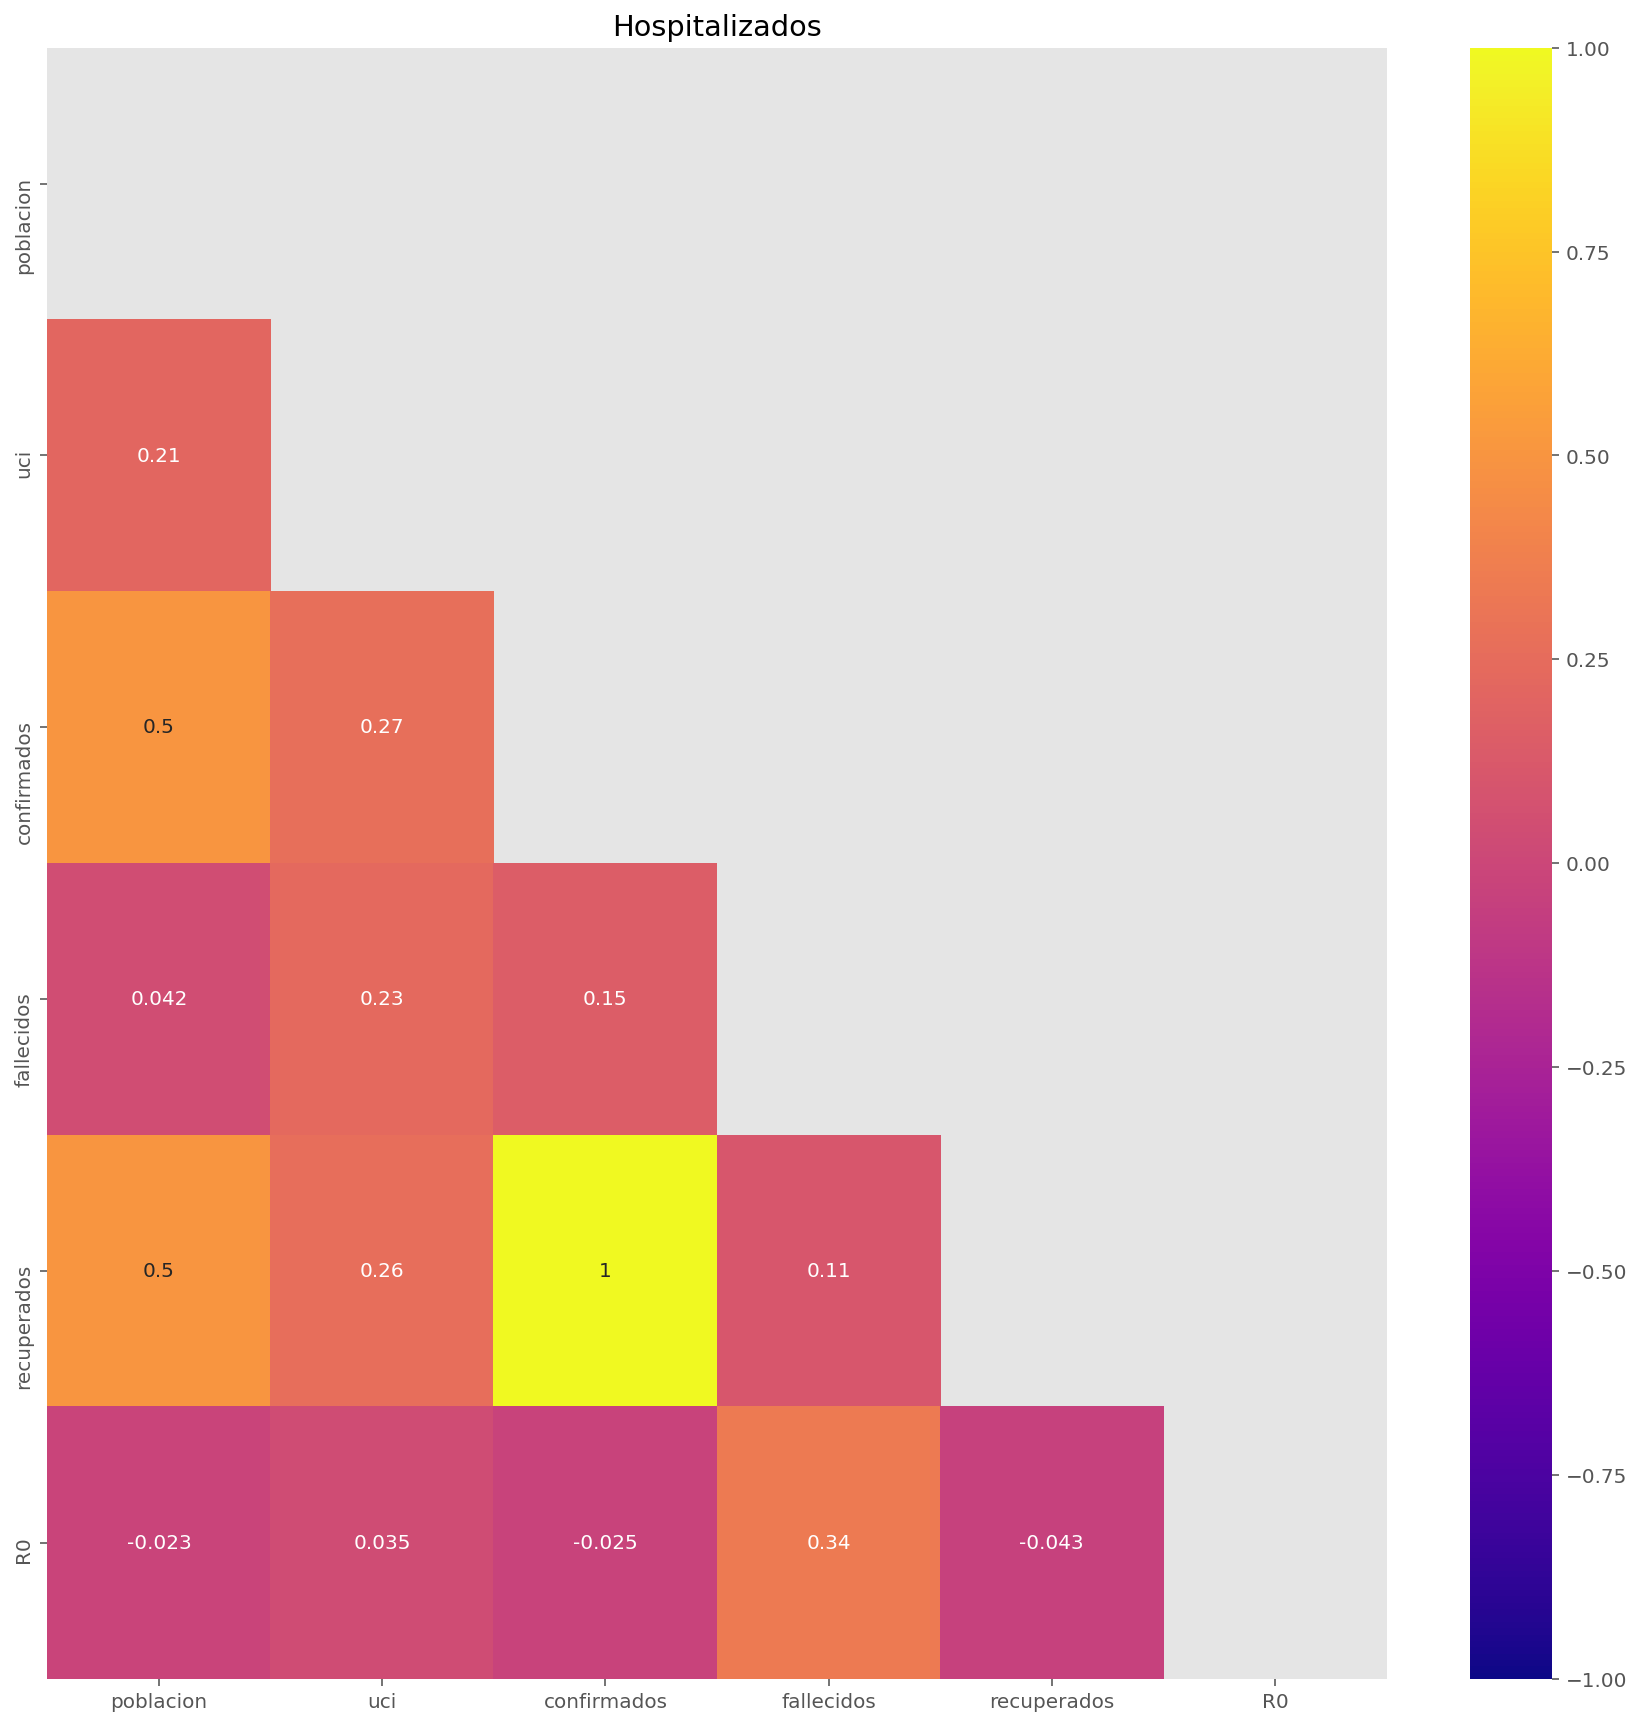

In [54]:
bd_hos = bd_epidem[['poblacion','uci', 'confirmados','fallecidos','recuperados', 'R0']]

#MATRIZ DE CORRELACIONES 
colormap = plt.cm.plasma
matrix1 = np.triu(bd_hos.corr())
plt.figure(figsize=(15, 15))
sns.heatmap(bd_hos.corr(), annot=True, vmax=1, vmin=-1, mask=matrix1, cmap=colormap)
plt.title("Hospitalizados")
plt.show()

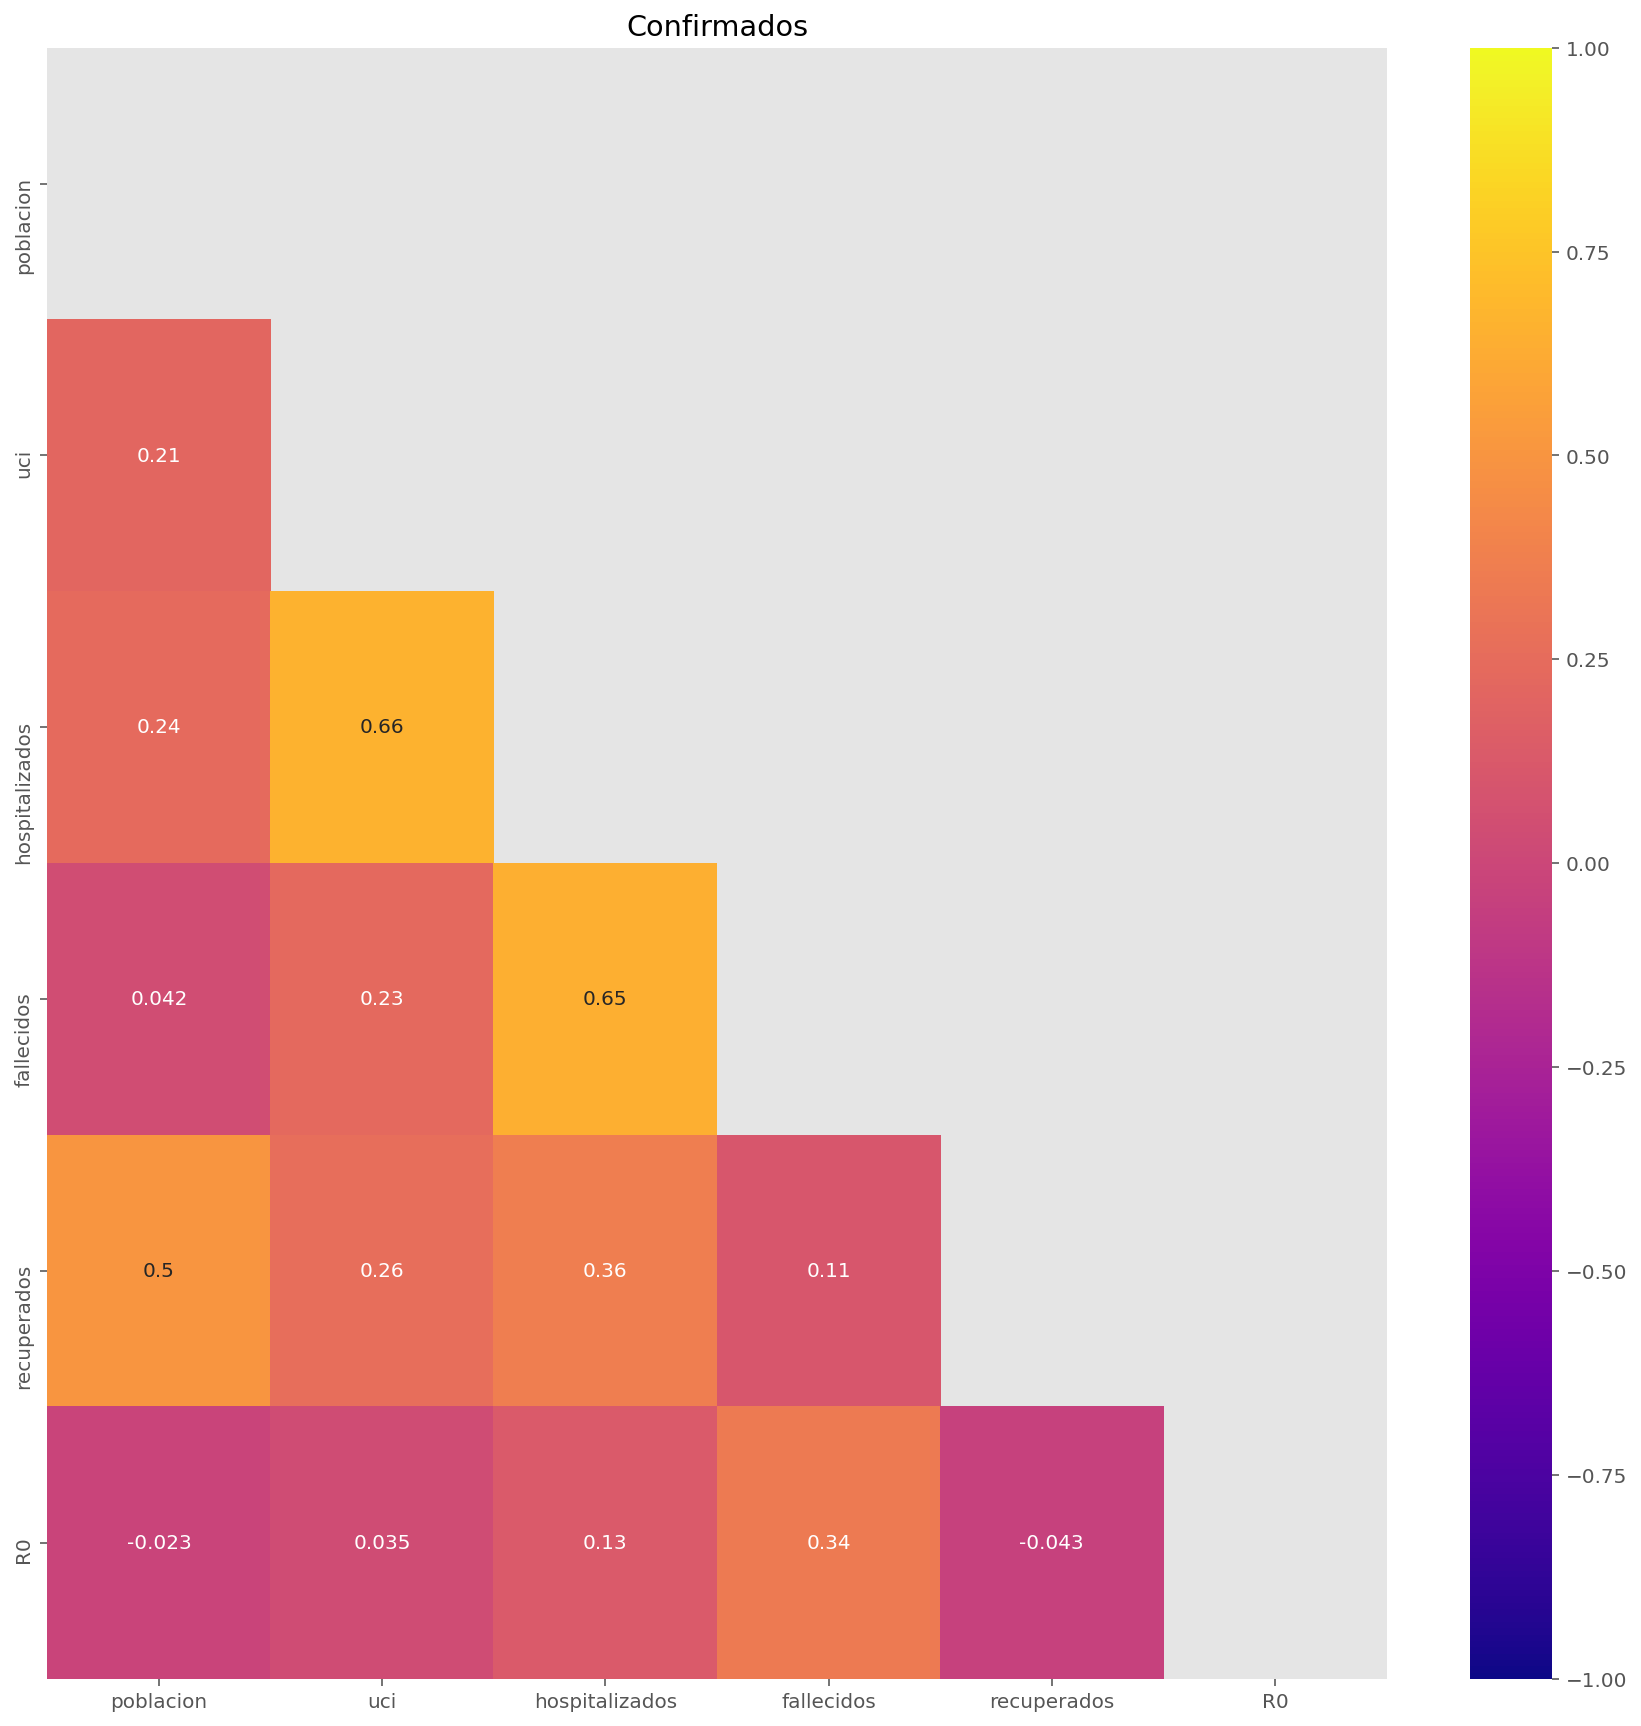

In [55]:
bd_conf = bd_epidem[['poblacion','uci', 'hospitalizados','fallecidos','recuperados', 'R0']]

#MATRIZ DE CORRELACIONES 
colormap = plt.cm.plasma
matrix1 = np.triu(bd_conf.corr())
plt.figure(figsize=(15, 15))
sns.heatmap(bd_conf.corr(), annot=True, vmax=1, vmin=-1, mask=matrix1, cmap=colormap)
plt.title("Confirmados")
plt.show()

Fallecidos


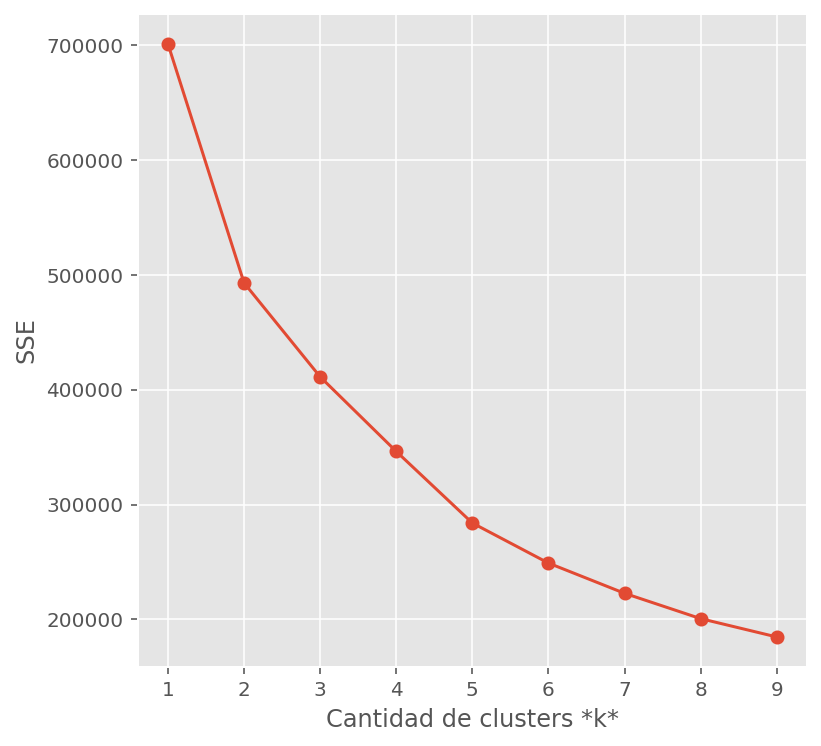

In [56]:
#ANALISIS CLUSTER - fallecidos

scaled_2 = scale(bd_fal)

sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(scaled_2)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters *k*')
plt.ylabel('SSE');
print('Fallecidos')

UCI


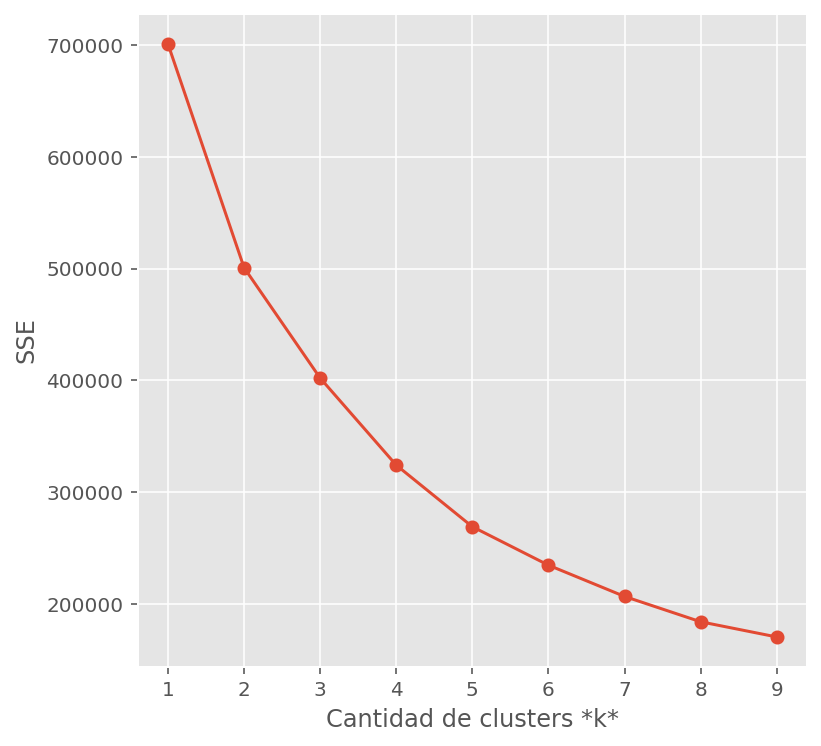

In [57]:
#ANALISIS CLUSTER - UCI

scaled_2 = scale(bd_uci)

sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(scaled_2)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters *k*')
plt.ylabel('SSE');
print('UCI')

Confirmados


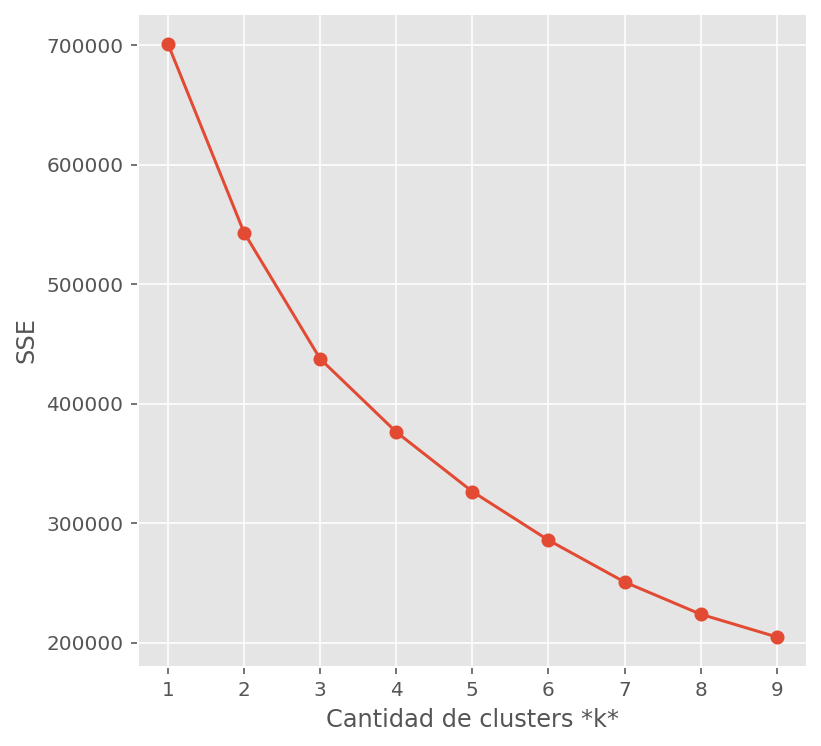

In [59]:
#ANALISIS CLUSTER - Confirmados

scaled_2 = scale(bd_conf)

sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(scaled_2)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters *k*')
plt.ylabel('SSE');
print('Confirmados')

Hospitalizados


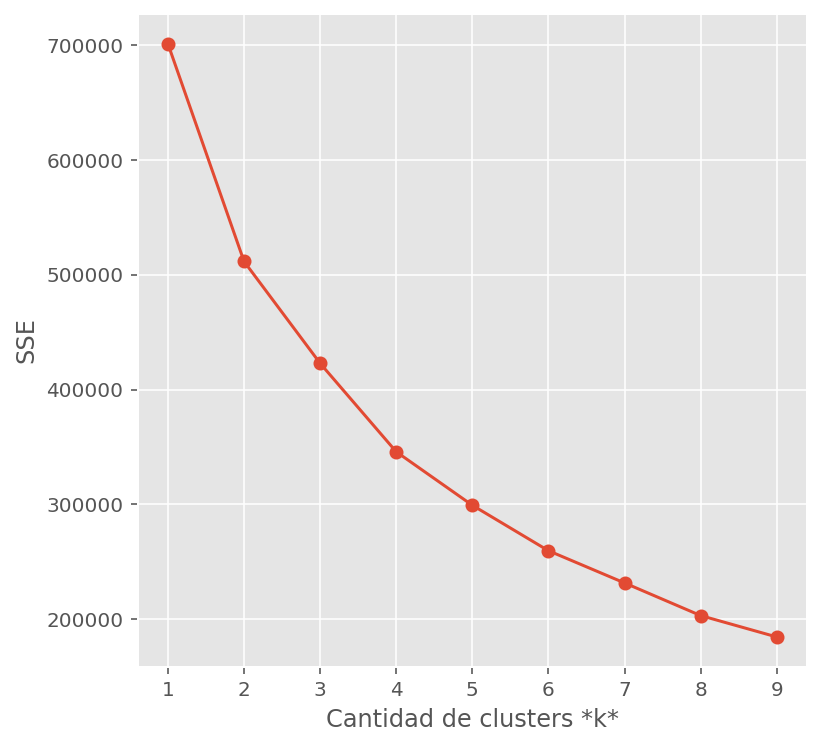

In [60]:
#ANALISIS CLUSTER - Hospitalizados

scaled_2 = scale(bd_hos)

sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(scaled_2)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters *k*')
plt.ylabel('SSE');
print('Hospitalizados')

In [ ]:
#import plotly.express as px
fig = px.treemap(today_Sub_2a, path=['cluster','ccaa'], values='confirmados')
fig.update_layout(autosize=False,width=800,height=700)

fig.show()

In [61]:
# ajustado el algoritmo Kmeans ak conjunto de datos. Elijo 4 clústers
from sklearn.cluster import KMeans

## Numero de clústers a utilizar. En este caso 4 clústers
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(bd_fal)
y_kmeans1=y_kmeans+1
cluster = pd.DataFrame(y_kmeans1)
today_sub=bd_fal
# Adding cluster to the Dataset
today_sub['cluster'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(today_sub.groupby('cluster').mean(),1))

## Identificación de los valores promedio (centroides) 
kmeans_mean_cluster

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,poblacion,uci,hospitalizados,confirmados,recuperados,R0
cluster,,,,,,
1.0,178547.2,0.5,6.2,13.8,12.2,1.1
2.0,178102.2,0.5,5.9,14.6,13.0,1.1
3.0,185709.9,0.5,4.9,12.5,11.4,1.1
4.0,189714.4,0.6,6.7,14.7,13.0,1.1


In [ ]:
# DEBERIA SER EL SUMATORIO NO ????


today_Sub_2=pd.concat([bd_epidem[['ccaa']],bd_R0],axis=1)
today_Sub_2.head(5)

,ccaa,poblacion,uci,hospitalizados,confirmados,fallecidos,recuperados,cluster
14107,Madrid,589033,0,1,1,0,1,1.0
23906,Canarias,124436,0,0,1,0,1,2.0
31432,Islas Baleares,107231,0,1,1,0,1,2.0
33598,Cataluña,503828,0,0,1,0,1,1.0
33908,Madrid,513110,0,0,1,0,1,2.0


In [ ]:
for i in range(1,5):
    print('****Comunidades autónomas en el grupo {}*****'.format(str(i)))
    print(list(today_Sub_2[today_Sub_2.cluster==i]['ccaa'].values))

****Comunidades autónomas en el grupo 1*****
['Madrid', 'Cataluña', 'La Rioja', 'Madrid', 'Andalucía', 'Castilla y León', 'Cataluña', 'Madrid', 'Navarra', 'Andalucía', 'Aragón', 'Canarias', 'Cataluña', 'Cataluña', 'Madrid', 'Madrid', 'Extremadura', 'Madrid', 'Madrid', 'Madrid', 'Madrid', 'Madrid', 'Castilla y León', 'Cataluña', 'Cataluña', 'Madrid', 'País Vasco', 'Cataluña', 'Comunidad Valenciana', 'Comunidad Valenciana', 'Comunidad Valenciana', 'Islas Baleares', 'Madrid', 'Madrid', 'Madrid', 'Madrid', 'Madrid', 'Madrid', 'Madrid', 'Castilla y León', 'Castilla-La Mancha', 'Castilla-La Mancha', 'Castilla-La Mancha', 'Comunidad Valenciana', 'Comunidad Valenciana', 'Galicia', 'La Rioja', 'La Rioja', 'Madrid', 'Madrid', 'Madrid', 'Madrid', 'Cataluña', 'Comunidad Valenciana', 'Comunidad Valenciana', 'Islas Baleares', 'La Rioja', 'Madrid', 'Madrid', 'País Vasco', 'País Vasco', 'País Vasco', 'País Vasco', 'Andalucía', 'Andalucía', 'Aragón', 'Cataluña', 'Comunidad Valenciana', 'Comunidad Valen

In [ ]:
import plotly
import plotly.express as px

In [ ]:
fig = px.treemap(today_Sub_2, path=['cluster','ccaa'], values='hospitalizados')
fig.update_layout(autosize=False,width=800,height=700)

fig.show()

ValueError: ignored

# Modelo Lineal

In [ ]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# División de los datos en train y test
# ==============================================================================
#df2 = df1.drop(['ccaa'], axis = 1)

X = df2
y = df1['Infectados1M(2021)'] # infectados totales

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [ ]:
# Creación del modelo utilizando matrices como en scikitlearn
# ==============================================================================
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

In [ ]:
# FUENTE: https://aprendeia.com/regresion-lineal-multiple-machine-learning-practica-con-python/

X_multiple = df1.iloc[:, 2:10]
from sklearn import datasets, linear_model
y_multiple = df1['Infectados1M(2021)']+ df1['Infectados1M(2020)']

from sklearn.model_selection import train_test_split
#Separo los datos de "train" en entrenamiento y prueba para probar los algoritmos
X_train, X_test, y_train, y_test = train_test_split(X_multiple, y_multiple, test_size=0.2)

#Defino el algoritmo a utilizar
lr_multiple = linear_model.LinearRegression()

#Entreno el modelo
lr_multiple.fit(X_train, y_train)

In [ ]:
#Realizo una predicción
Y_pred_multiple = lr_multiple.predict(X_test)

print('DATOS DEL MODELO REGRESIÓN LINEAL MULTIPLE')
print()
print('Valor de las pendientes o coeficientes "a":')
print(lr_multiple.coef_)
print('Valor de la intersección o coeficiente "b":')
print(lr_multiple.intercept_)

print('Precisión del modelo:')
print(lr_multiple.score(X_train, y_train))

# Modelo no Lineal

In [ ]:
!pip install git+https://github.com/scikit-learn-contrib/py-earth@v0.2dev

In [ ]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import seaborn as sns

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style

# Ajuste de distribuciones
# ==============================================================================
from scipy import stats
import inspect
from statsmodels.distributions.empirical_distribution import ECDF

# Configuración matplotlib
# ==============================================================================
#plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy
from pyearth import Earth
from matplotlib import pyplot

X = df1.iloc[:, 2:10]
y= df1['Infectados1M(2021)']+ df1['Infectados1M(2020)']

#Fit an Earth model
model = Earth()
model.fit(X,y)

#Print the model
print(model.trace())
print(model.summary())


#Plot the model
y_hat = model.predict(X)
pyplot.figure()
#pyplot.plot(X[:,6],y,'r.')
#pyplot.plot(X[:,6],y_hat,'b.')
pyplot.xlabel('x_6')
pyplot.ylabel('y')
pyplot.title('Simple Earth Example')
pyplot.show()

In [ ]:
# Gráficos distribución observada (empírica)
# ==============================================================================

datos = df1['Infectados1M(2021)']+ df1['Infectados1M(2020)']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Histograma
axs[0].hist(x=datos, bins=30, color="#3182bd", alpha=0.5)
axs[0].plot(datos, np.full_like(datos, -0.01), '|k', markeredgewidth=1)
axs[0].set_title('Distribución empírica de la tasa de infectados')
axs[0].set_xlabel('precio')
axs[0].set_ylabel('counts')

# Función de Distribución Acumulada
# ecdf (empirical cumulative distribution function)
ecdf = ECDF(x=datos)
axs[1].plot(ecdf.x, ecdf.y, color="#3182bd")
axs[1].set_title('Función de distribución empírica')
axs[1].set_xlabel('variables')
axs[1].set_ylabel('infectados')

plt.tight_layout();

# nube de puntos


In [ ]:
XY_train = df1.iloc[:, 2:10]
z_train = df1['Infectados1M(2021)']+ df1['Infectados1M(2020)']


# Creamos un nuevo objeto de Regresión Lineal
regr2 = linear_model.LinearRegression()
 
# Entrenamos el modelo, esta vez, con 2 dimensiones
# obtendremos 2 coeficientes, para graficar un plano
regr2.fit(XY_train, z_train)
 
# Hacemos la predicción con la que tendremos puntos sobre el plano hallado
z_pred = regr2.predict(XY_train)
 
# Los coeficientes
print('Coefficients: \n', regr2.coef_)
# Error cuadrático medio
print("Mean squared error: %.2f" % mean_squared_error(z_train, z_pred))
# Evaluamos el puntaje de varianza (siendo 1.0 el mejor posible)
print('Variance score: %.2f' % r2_score(z_train, z_pred))

In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from tabulate import tabulate

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge

from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

# Varios
# ==============================================================================
import multiprocessing
import random
from itertools import product
from fitter import Fitter, get_common_distributions

In [ ]:
# Validación cruzada
# ==============================================================================
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )

print(f"Métricas validación cruzada: {cv_scores}")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")